# Age, Gender, and Expression Recognition

## Notebook Imports

In [1]:
import os
import pathlib
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
from tqdm.autonotebook import tqdm
from timeit import default_timer as timer

import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
torch.__version__

/tmp/ipykernel_17/3646614456.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


'2.4.0+cpu'

## Data Loading & Data Preprocessing

In [2]:
EMOTION_IMAGE_PATH = Path("/kaggle/input/emotion-detection-fer")
EMOTION_TRAIN_PATH = EMOTION_IMAGE_PATH / "train"
EMOTION_TEST_PATH = EMOTION_IMAGE_PATH / "test"
EMOTION_IMAGE_PATH_LIST = list(EMOTION_IMAGE_PATH.glob('*/*/*.png'))

AGEUTK = Path("/kaggle/input/ageutk")
AGEUTK_PATH_LIST = list((AGEUTK / 'UTKFace').glob("*/*/*.jpg.chip.jpg"))

In [3]:
def parse_filename(filename):
    parts = filename.split("_")
    return {"path": f"/kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/{filename}", "age": int(parts[0]), "gender": int(parts[1])}

In [4]:
age_bins = [i for i in range(0, 81, 5)]
age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]

ageutkface_data = [parse_filename(path.name) for path in AGEUTK_PATH_LIST]
AGEUTK_METADATA = pd.DataFrame(ageutkface_data)
AGEUTK_METADATA['age'] = pd.cut(
    AGEUTK_METADATA['age'], bins=age_bins, labels=age_labels, right=False
)
AGEUTK_METADATA.head()

,path,age,gender
0,/kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...,25-29,0
1,/kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...,20-24,1
2,/kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...,20-24,1
3,/kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...,25-29,0
4,/kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...,15-19,1


In [5]:
emotion_data = [{'path': path, 'emotion': path.parent.stem} for path in EMOTION_IMAGE_PATH_LIST]
EMOTION_METADATA = pd.DataFrame(emotion_data)
EMOTION_METADATA.head()

,path,emotion
0,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
1,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
2,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
3,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
4,/kaggle/input/emotion-detection-fer/test/fearf...,fearful


In [6]:
AGEUTK_METADATA.columns, EMOTION_METADATA.columns

(Index(['path', 'age', 'gender'], dtype='object'),
 Index(['path', 'emotion'], dtype='object'))

In [7]:
AGEUTK_METADATA[AGEUTK_METADATA['age'] == 'nan']

,path,age,gender


## Data Transformation

In [8]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None, emotion=True):
    """Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version."""
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            if emotion:
                f = f.convert('RGB')
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # Original Image
            ax[0].imshow(f)
            ax[0].set_title(f'Original Image \nSize: {f.size}')
            ax[0].axis(False)

            # Transformed Image
            transformed_image = transform(f).permute(1, 2, 0) # (C, H, W) -> (H, W, C) for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed Image \nSize: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=14)

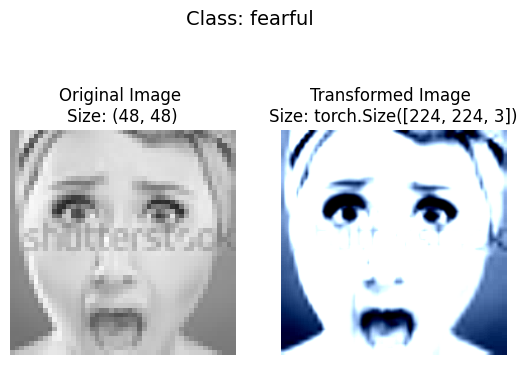

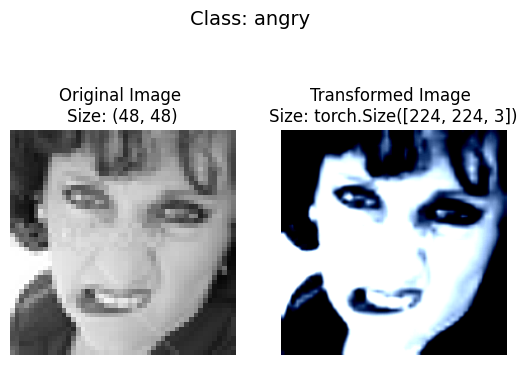

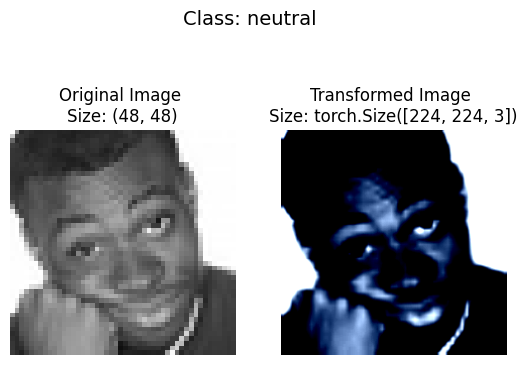

In [10]:
plot_transformed_images(image_paths=EMOTION_IMAGE_PATH_LIST,
                        transform=train_transform,
                        n=3,
                        seed=42)

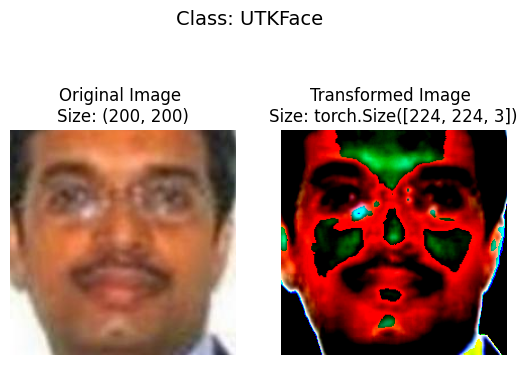

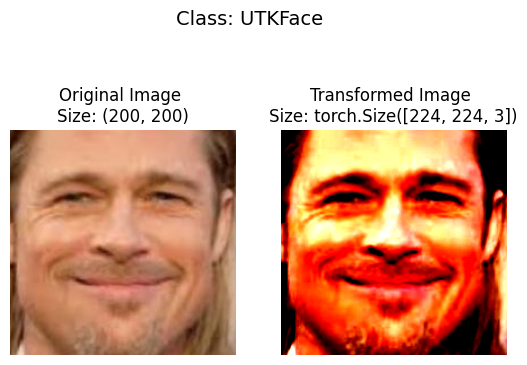

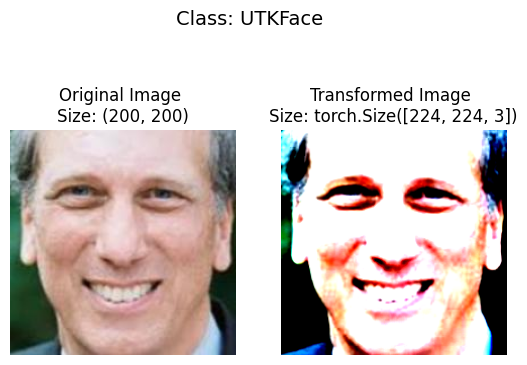

In [11]:
plot_transformed_images(image_paths=AGEUTK_PATH_LIST,
                        transform=train_transform,
                        n=3, emotion=False,
                        seed=42)

## Combining Emotion and UTKFace Datasets

Creating a custom PyTorch Dataset class to integrate the datasets for emotion, age, and gender

In [12]:
emotion_idx = {
    'angry': 0,
    'disgusted': 1,
    'fearful': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprised': 6
}

age_idx = {label:i for i, label in enumerate(age_labels)}
age_idx['nan'] = None

In [13]:
class CombinedCustomDataset(Dataset):
    def __init__(self, emotion_metadata, ageutkface_metadata, emotion_idx:dict, age_idx:dict, transform=None):
        self.ageutk_df = ageutkface_metadata
        self.emotion_df = emotion_metadata
        self.transform = transform
        self.emotion_idx = emotion_idx
        self.age_idx = age_idx

    def __len__(self):
        return len(self.ageutk_df) + len(self.emotion_df)

    def __getitem__(self, idx):
        if idx < len(self.ageutk_df):  # AGE-UTK sample
            row = self.ageutk_df.iloc[idx]
            image = Image.open(row['path'])
            label = {
                'age': self.age_idx[row['age']],
                'gender': row['gender'],
                'emotion': None  # Emotion not applicable for AGE-UTK
            }
        else:  # Emotion sample
            row = self.emotion_df.iloc[idx - len(self.ageutk_df)]
            image = Image.open(row['path']).convert('RGB')
            label = {
                'age': None,  # Age not applicable for Emotion
                'gender': None,  # Gender not applicable for Emotion
                'emotion': emotion_idx[row['emotion']]
            }
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [14]:
def custom_collate_fn(batch):
    images = []
    labels = []

    for sample in batch:
        image, label = sample
        images.append(image)
        # Convert label dictionary to a tuple (age, gender, emotion)
        labels.append([label['age'], label['gender'], label['emotion']])

    # Stack images into a single tensor
    images = torch.stack(images)

    return images, labels

In [15]:
combined_dataset = CombinedCustomDataset(emotion_metadata=EMOTION_METADATA, ageutkface_metadata=AGEUTK_METADATA, 
                                         transform=train_transform, emotion_idx=emotion_idx, age_idx=age_idx)

combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True, 
                                 collate_fn=custom_collate_fn, num_workers=os.cpu_count())

In [16]:
images, labels = next(iter(combined_dataloader))
images.shape, len(labels)

(torch.Size([32, 3, 224, 224]), 32)

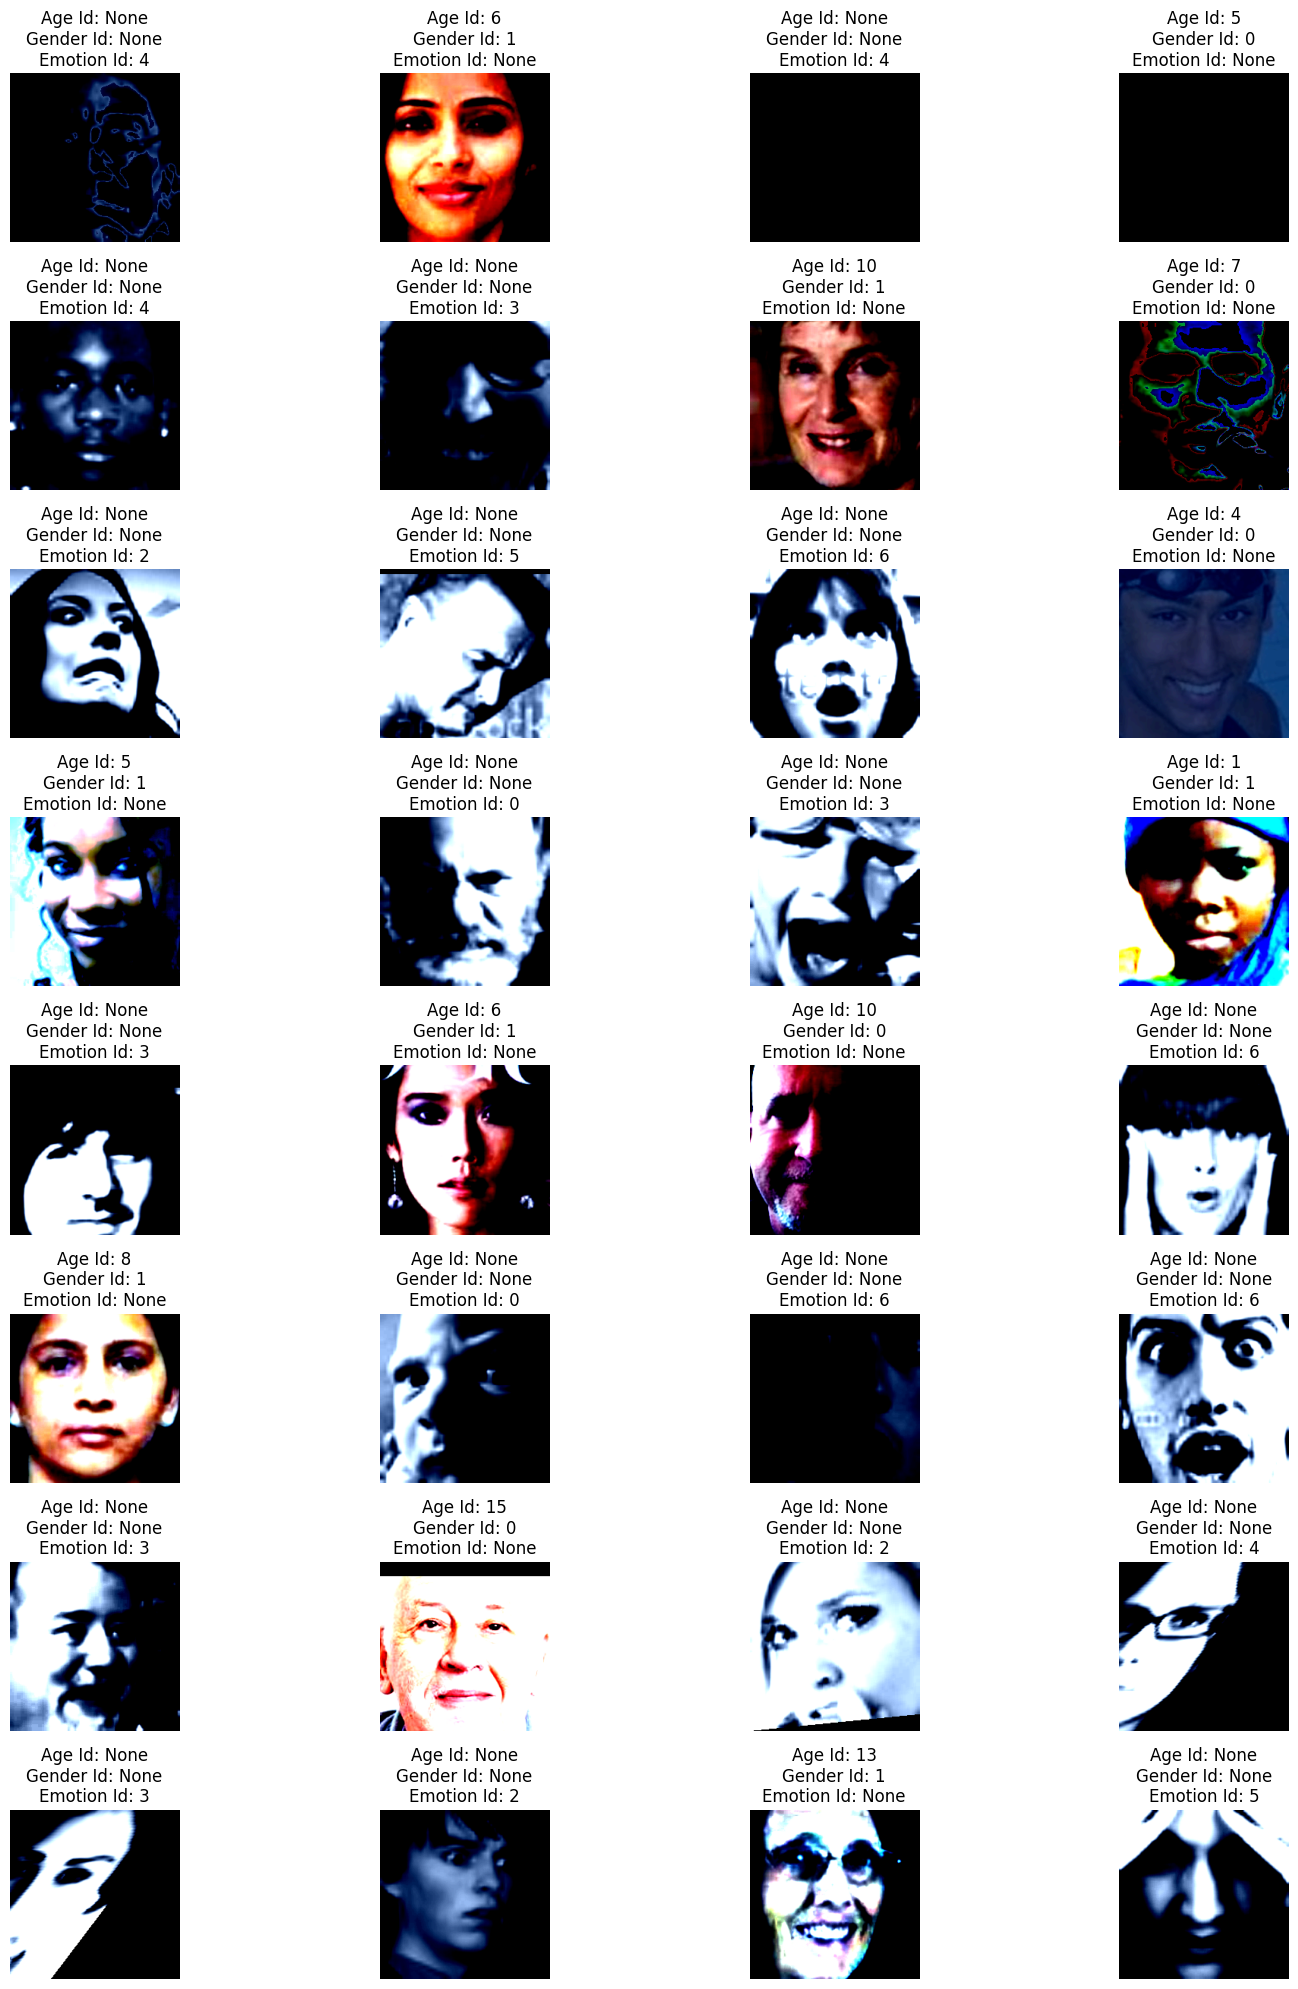

In [17]:
# Visualize images with their labels
def visualize_batch(images, labels):
    """
    Visualizes a batch of images in an 8x4 grid.
    
    Parameters:
        images (torch.Tensor): Batch of images (B, C, H, W).
        labels (list): Corresponding labels [(age_idx, gender_idx, emotion_idx), ...].
    """
    # Define the grid size
    rows, cols = 8, 4
    fig, axes = plt.subplots(rows, cols, figsize=(16, 20))
    
    for i, ax in enumerate(axes.flatten()):
        if i >= len(images):
            ax.axis('off')
            continue
        
        image = images[i]
        
        # Display the image
        ax.imshow(image.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
        ax.set_title(f"Age Id: {labels[i][0]}\nGender Id: {labels[i][1]}\nEmotion Id: {labels[i][2]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_batch(images, labels)

## Model Training & Evaluation

## Edge Deployment & Testing